In [14]:
import os
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from peft import PeftModel
from qwen_vl_utils import process_vision_info
from PIL import Image
import torch

In [15]:
# =============================
# 1. Load Base Model + LoRA Adapter
# =============================
BASE_MODEL = "Qwen/Qwen2.5-VL-7B-Instruct"
LORA_PATH = "/root/project/step1-vgjson-grounding-lora/checkpoint-4100"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True,
)

model = PeftModel.from_pretrained(base_model, LORA_PATH)
model.eval()

processor = AutoProcessor.from_pretrained(BASE_MODEL, use_fast=True, trust_remote_code=True)


Loading checkpoint shards: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


In [30]:

# =============================
# 2. Prepare Input
# =============================
IMG_PATH = "/root/project/data/visual_genome/VG_100K_2/1.jpg" 
prompt = "Describe this image."

image = Image.open(IMG_PATH).convert("RGB").resize((448, 448))

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": prompt},
        ],
    }
]


In [31]:

# =============================
# 3. Run Inference
# =============================
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
image_inputs, video_inputs = process_vision_info(messages)

inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    return_tensors="pt",
    padding=True,
).to(device)

generated_ids = model.generate(
    **inputs,
    max_new_tokens=1024,
    do_sample=False,
    temperature=0.7,
    top_k=50,
    top_p=0.95
)

generated_ids_trimmed = [
    out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]

output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=True
)


/root/miniconda3/envs/qwenvl/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/root/miniconda3/envs/qwenvl/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


In [32]:
# =============================
# 4. Output
# =============================
print(output_text[0])


let me explain all objects in the image.
[objects] man at (231, 145, 286, 297), woman at (140, 145, 182, 297), street at (190, 151, 332, 200), bicycle at (180, 182, 201, 204), tree at (280, 0, 332, 257), tree at (200, 0, 254, 200), tree at (254, 0, 300, 247), tree at (300, 0, 350, 247), tree at (349, 0, 400, 310), tree at (399, 0, 449, 310), tree at (349, 0, 400, 247), tree at (399, 0, 449, 310), tree at (254, 0, 300, 247), tree at (200, 0, 254, 200), tree at (280, 0, 332, 257), tree at (349, 0, 400, 247), tree at (399, 0, 449, 310), tree at (254, 0, 300, 247), tree at (200, 0, 254, 200), tree at (280, 0, 332, 257), tree at (349, 0, 400, 247), tree at (399, 0, 449, 310), tree at (254, 0, 300, 247), tree at (200, 0, 254, 200), tree at (280, 0, 332, 257), tree at (349, 0, 400, 247), tree at (399, 0, 449, 310), tree at (254, 0, 300, 247), tree at (200, 0, 254, 200), tree at (280, 0, 332, 257), tree at (349, 0, 400, 247), tree at (399, 0, 449, 310), tree at (254, 0, 300, 247), tree at (200

📦 감지된 객체 수: 50


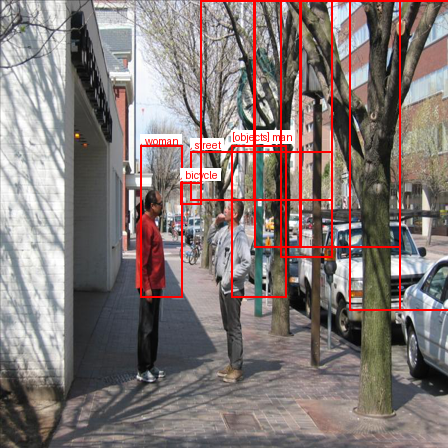

In [33]:
import re
from PIL import Image, ImageDraw, ImageFont

# =============================
# 1. 입력 설정
# =============================
OUTPUT_TEXT = output_text[0]
# =============================
# 2. 객체 정보 파싱
# =============================
pattern = re.compile(r"(.*?) at \((\d+), (\d+), (\d+), (\d+)\)")
objects = pattern.findall(OUTPUT_TEXT)

print(f"📦 감지된 객체 수: {len(objects)}")

# =============================
# 3. 이미지 로드 및 시각화
# =============================
draw = ImageDraw.Draw(image)

# Optional: 폰트 설정 (없는 경우 기본 사용)
try:
    font = ImageFont.truetype("arial.ttf", 16)
except:
    font = ImageFont.load_default()

for cls, x1, y1, x2, y2 in objects:
    box = [int(x1), int(y1), int(x2), int(y2)]
    draw.rectangle(box, outline="red", width=2)

    label = cls.strip()
    bbox = font.getbbox(label)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    text_position = (int(x1), int(y1) - text_height - 4)

    # 배경 박스 (흰색)
    draw.rectangle(
        [text_position, (text_position[0] + text_width + 2, text_position[1] + text_height + 2)],
        fill="white"
    )

    # 텍스트 (빨간색)
    draw.text((text_position[0] + 1, text_position[1] + 1), label, fill="red", font=font)



# =============================
# 4. 저장 및 표시
# =============================
# image.save("output_visualized.jpg")
image.show()

In [34]:
objects

[('[objects] man', '231', '145', '286', '297'),
 (', woman', '140', '145', '182', '297'),
 (', street', '190', '151', '332', '200'),
 (', bicycle', '180', '182', '201', '204'),
 (', tree', '280', '0', '332', '257'),
 (', tree', '200', '0', '254', '200'),
 (', tree', '254', '0', '300', '247'),
 (', tree', '300', '0', '350', '247'),
 (', tree', '349', '0', '400', '310'),
 (', tree', '399', '0', '449', '310'),
 (', tree', '349', '0', '400', '247'),
 (', tree', '399', '0', '449', '310'),
 (', tree', '254', '0', '300', '247'),
 (', tree', '200', '0', '254', '200'),
 (', tree', '280', '0', '332', '257'),
 (', tree', '349', '0', '400', '247'),
 (', tree', '399', '0', '449', '310'),
 (', tree', '254', '0', '300', '247'),
 (', tree', '200', '0', '254', '200'),
 (', tree', '280', '0', '332', '257'),
 (', tree', '349', '0', '400', '247'),
 (', tree', '399', '0', '449', '310'),
 (', tree', '254', '0', '300', '247'),
 (', tree', '200', '0', '254', '200'),
 (', tree', '280', '0', '332', '257'),
 (',